# Question 2: Social Network Analysis with the Facebook100 Dataset

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os

os.makedirs('plots', exist_ok=True)

def save_plot(plt, name, plot_type):
    """Save plot with standardized filename"""
    filename = f"plots/{name.replace(' ', '_')}_{plot_type}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

networks = {
    'Caltech': nx.read_gml('./data/Caltech36.gml'),
    'MIT': nx.read_gml('./data/MIT8.gml'),
    'Johns Hopkins': nx.read_gml('./data/Johns Hopkins55.gml')
}

for name, G in networks.items():
    G = G.subgraph(max(nx.connected_components(G), key=len))

    plt.figure(figsize=(10, 6))
    degrees = [d for n, d in G.degree()]
    plt.hist(degrees, bins=50, density=True, alpha=0.7)
    plt.title(f'Degree Distribution - {name}')
    plt.xlabel('Degree')
    plt.ylabel('Probability')
    #plt.xscale('log')
    #plt.yscale('log')
    plt.grid(True)
    save_plot(plt, name, 'degree_distribution')

    global_clustering = nx.average_clustering(G)
    local_clustering = nx.clustering(G)
    mean_local_clustering = np.mean(list(local_clustering.values()))
    edge_density = nx.density(G)

    print(f"\n{name} Network Analysis:")
    print(f"Nodes in LCC: {G.number_of_nodes()}")
    print(f"Global Clustering: {global_clustering:.4f}")
    print(f"Mean Local Clustering: {mean_local_clustering:.4f}")
    print(f"Edge Density: {edge_density:.4f}")

    plt.figure(figsize=(10, 6))
    degrees = [G.degree(n) for n in G.nodes()]
    clustering_coeffs = [local_clustering[n] for n in G.nodes()]
    plt.scatter(degrees, clustering_coeffs, alpha=0.5)
    plt.xlabel('Degree')
    plt.ylabel('Local Clustering Coefficient')
    plt.title(f'Degree vs Local Clustering - {name}')
    #plt.xscale('log')
    plt.grid(True)
    save_plot(plt, name, 'degree_vs_clustering')






Caltech Network Analysis:
Nodes in LCC: 762
Global Clustering: 0.4091
Mean Local Clustering: 0.4091
Edge Density: 0.0574

MIT Network Analysis:
Nodes in LCC: 6402
Global Clustering: 0.2724
Mean Local Clustering: 0.2724
Edge Density: 0.0123

Johns Hopkins Network Analysis:
Nodes in LCC: 5157
Global Clustering: 0.2690
Mean Local Clustering: 0.2690
Edge Density: 0.0140


# Q3 Assortativity Analysis with the Facebook100 Dataset

## All combined

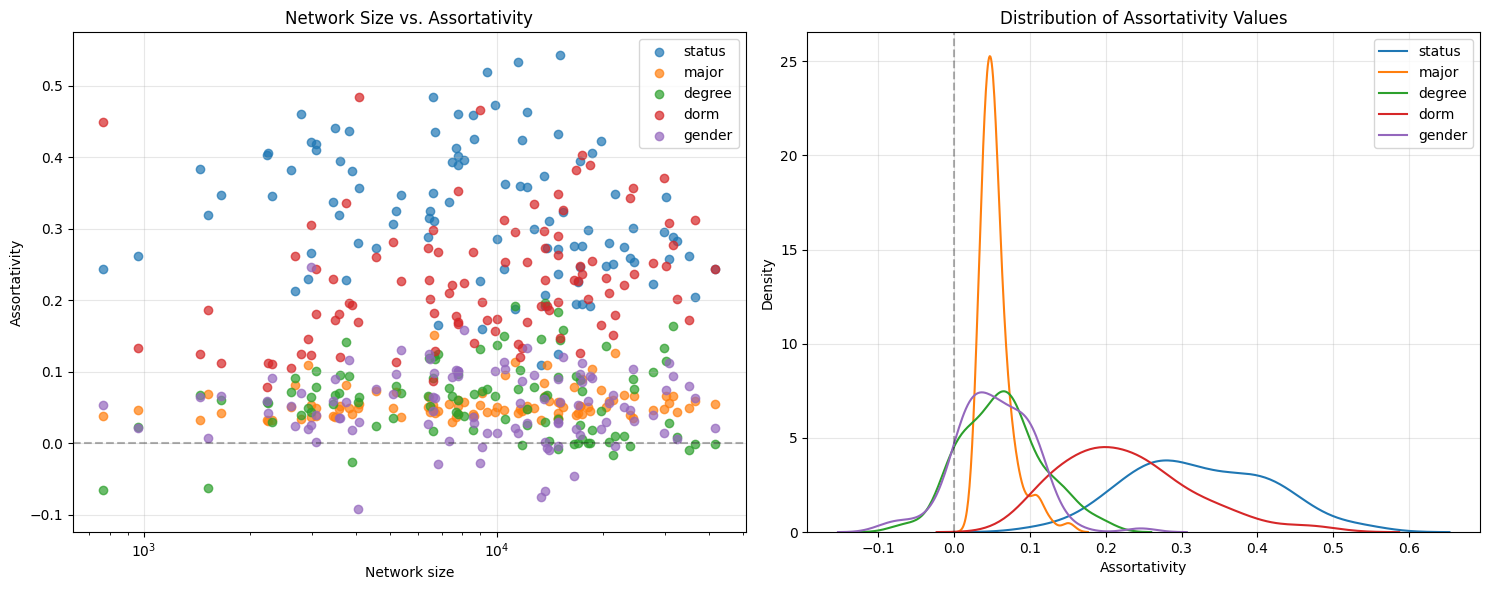


Assortativity Results:
--------------------------------------------------------------------------------
Network                  Status      Major     Degree       Dorm     Gender
--------------------------------------------------------------------------------
American75.gml            0.288      0.051      0.066      0.273      0.027
Cornell5.gml              0.406      0.104      0.018      0.254      0.091
MU78.gml                  0.323      0.050      0.158      0.326      0.121
Rice31.gml                0.358      0.055      0.065      0.485      0.030
UC61.gml                  0.208      0.067      0.197      0.273      0.003
USFCA72.gml               0.212      0.082      0.092      0.262      0.024
Amherst41.gml             0.403      0.032      0.058      0.079      0.060
Dartmouth6.gml            0.412      0.037      0.044      0.178      0.103
Maine59.gml               0.160      0.070      0.073      0.197     -0.005
Rochester38.gml           0.273      0.073      0.025 

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

def load_and_analyze_network(filename):
    """Load network and compute assortativity for different attributes"""
    try:
        G = nx.read_gml(f"data/{filename}")

        results = {}

        results['degree'] = nx.degree_assortativity_coefficient(G)

        attr_mapping = {
            'student_fac': 'status',
            'major_index': 'major',
            'dorm': 'dorm',
            'gender': 'gender'
        }

        for data_attr, display_name in attr_mapping.items():
            try:
                valid_nodes = [(u, v) for (u, v) in G.edges()
                             if G.nodes[u].get(data_attr, 0) != 0
                             and G.nodes[v].get(data_attr, 0) != 0]

                if valid_nodes:
                    sub_G = G.edge_subgraph(valid_nodes)
                    results[display_name] = nx.attribute_assortativity_coefficient(sub_G, data_attr)
                else:
                    results[display_name] = np.nan
            except Exception as e:
                print(f"Error computing {display_name} assortativity: {str(e)}")
                results[display_name] = np.nan

        return G, results, True
    except Exception as e:
        print(f"Error processing {filename}: {str(e)}")
        return None, None, False

def plot_assortativity_results(networks_results):
    """Create visualization of assortativity patterns"""
    attributes = ['status', 'major', 'degree', 'dorm', 'gender']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Network size vs assortativity
    for attr in attributes:
        sizes = []
        values = []
        for data in networks_results.values():
            if data['results'][attr] is not None and not np.isnan(data['results'][attr]):
                sizes.append(nx.number_of_nodes(data['graph']))
                values.append(data['results'][attr])

        if sizes and values:
            ax1.scatter(sizes, values, label=attr, alpha=0.7)

    ax1.set_xscale('log')
    ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax1.set_xlabel('Network size')
    ax1.set_ylabel('Assortativity')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_title('Network Size vs. Assortativity')

    # Plot 2: Distribution of assortativity values
    for attr in attributes:
        values = [data['results'][attr] for data in networks_results.values()
                 if data['results'][attr] is not None and not np.isnan(data['results'][attr])]
        if len(values) > 1:
            sns.kdeplot(data=values, label=attr, ax=ax2)

    ax2.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    ax2.set_xlabel('Assortativity')
    ax2.set_ylabel('Density')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_title('Distribution of Assortativity Values')

    plt.tight_layout()
    return fig

networks = [
    'American75.gml',
    'Cornell5.gml',
    'MU78.gml',
    'Rice31.gml',
    'UC61.gml',
    'USFCA72.gml',
    'Amherst41.gml',
    'Dartmouth6.gml',
    'Maine59.gml',
    'Rochester38.gml',
    'UC64.gml',
    'UVA16.gml',
    'Auburn71.gml',
    'Duke14.gml',
    'Maryland58.gml',
    'Rutgers89.gml',
    'UCF52.gml',
    'Vanderbilt48.gml',
    'BC17.gml',
    'Emory27.gml',
    'Mich67.gml',
    'Santa74.gml',
    'UCLA26.gml',
    'Vassar85.gml',
    'BU10.gml',
    'FSU53.gml',
    'Michigan23.gml',
    'Simmons81.gml',
    'UCSB37.gml',
    'Vermont70.gml',
    'Baylor93.gml',
    'GWU54.gml',
    'Middlebury45.gml',
    'Smith60.gml',
    'UCSC68.gml',
    'Villanova62.gml',
    'Berkeley13.gml',
    'Georgetown15.gml',
    'Mississippi66.gml',
    'Stanford3.gml',
    'UCSD34.gml',
    'Virginia63.gml',
    'Bingham82.gml',
    'Hamilton46.gml',
    'NYU9.gml',
    'Swarthmore42.gml',
    'UChicago30.gml',
    'Wake73.gml',
    'Bowdoin47.gml',
    'Harvard1.gml',
    'Northeastern19.gml',
    'Syracuse56.gml',
    'UConn91.gml',
    'WashU32.gml',
    'Brandeis99.gml',
    'Haverford76.gml',
    'Northwestern25.gml',
    'Temple83.gml',
    'UF21.gml',
    'Wellesley22.gml',
    'Brown11.gml',
    'Howard90.gml',
    'Notre Dame57.gml',
    'Tennessee95.gml',
    'UGA50.gml',
    'Wesleyan43.gml',
    'Bucknell39.gml',
    'Indiana69.gml',
    'Oberlin44.gml',
    'Texas80.gml',
    'UIllinois20.gml',
    'William77.gml',
    'Cal65.gml',
    'JMU79.gml',
    'Oklahoma97.gml',
    'Texas84.gml',
    'UMass92.gml',
    'Williams40.gml',
    'Caltech36.gml',
    'Johns Hopkins55.gml',
    'Penn94.gml',
    'Trinity100.gml',
    'UNC28.gml',
    'Wisconsin87.gml',
    'Carnegie49.gml',
    'Lehigh96.gml',
    'Pepperdine86.gml',
    'Tufts18.gml',
    'UPenn7.gml',
    'Yale4.gml',
    'Colgate88.gml',
    'MIT8.gml',
    'Princeton12.gml',
    'Tulane29.gml',
    'USC35.gml',
    'Columbia2.gml',
    'MSU24.gml',
    'Reed98.gml',
    'UC33.gml',
    'USF51.gml',

]
results = {}

for net in networks:
    G, assortativity_results, success = load_and_analyze_network(net)
    if success:
        results[net] = {
            'graph': G,
            'results': assortativity_results
        }

fig = plot_assortativity_results(results)
plt.show()

print("\nAssortativity Results:")
print("-" * 80)
print(f"{'Network':<20} {'Status':>10} {'Major':>10} {'Degree':>10} {'Dorm':>10} {'Gender':>10}")
print("-" * 80)

for net in results:
    values = results[net]['results']
    print(f"{net[:19]:<20} {values['status']:>10.3f} {values['major']:>10.3f} "
          f"{values['degree']:>10.3f} {values['dorm']:>10.3f} {values['gender']:>10.3f}")
print("-" * 80)

## Separated

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

def load_and_analyze_network(filename):
    """Load network and compute assortativity for different attributes"""
    try:
        G = nx.read_gml(f"data/{filename}")

        results = {}

        results['degree'] = nx.degree_assortativity_coefficient(G)

        attr_mapping = {
            'student_fac': 'status',
            'major_index': 'major',
            'dorm': 'dorm',
            'gender': 'gender'
        }

        for data_attr, display_name in attr_mapping.items():
            try:
                valid_nodes = [(u, v) for (u, v) in G.edges()
                             if G.nodes[u].get(data_attr, 0) != 0
                             and G.nodes[v].get(data_attr, 0) != 0]

                if valid_nodes:
                    sub_G = G.edge_subgraph(valid_nodes)
                    results[display_name] = nx.attribute_assortativity_coefficient(sub_G, data_attr)
                else:
                    results[display_name] = np.nan
            except Exception as e:
                print(f"Error computing {display_name} assortativity: {str(e)}")
                results[display_name] = np.nan

        return G, results, True
    except Exception as e:
        print(f"Error processing {filename}: {str(e)}")
        return None, None, False

def plot_single_attribute(networks_results, attribute, fig_number):
    """Create plots for a single attribute"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'Assortativity Analysis for {attribute.title()}')

    # Plot 1: Network size vs assortativity
    sizes = []
    values = []
    for data in networks_results.values():
        if data['results'][attribute] is not None and not np.isnan(data['results'][attribute]):
            sizes.append(nx.number_of_nodes(data['graph']))
            values.append(data['results'][attribute])

    if sizes and values:
        ax1.scatter(sizes, values, label=attribute, alpha=0.7)

    ax1.set_xscale('log')
    ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax1.set_xlabel('Network size')
    ax1.set_ylabel('Assortativity')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_title('Network Size vs. Assortativity')

    # Plot 2: Distribution of assortativity values
    values = [data['results'][attribute] for data in networks_results.values()
             if data['results'][attribute] is not None and not np.isnan(data['results'][attribute])]
    if len(values) > 1:
        sns.kdeplot(data=values, ax=ax2, label=attribute)

    ax2.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    ax2.set_xlabel('Assortativity')
    ax2.set_ylabel('Density')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_title('Distribution of Assortativity Values')

    plt.tight_layout()
    return fig

def plot_combined_view(networks_results):
    """Create combined view of all attributes"""
    attributes = ['status', 'major', 'degree', 'dorm', 'gender']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Combined Assortativity Analysis for All Attributes')

    # Plot 1: Network size vs assortativity
    for attr in attributes:
        sizes = []
        values = []
        for data in networks_results.values():
            if data['results'][attr] is not None and not np.isnan(data['results'][attr]):
                sizes.append(nx.number_of_nodes(data['graph']))
                values.append(data['results'][attr])

        if sizes and values:
            ax1.scatter(sizes, values, label=attr, alpha=0.7)

    ax1.set_xscale('log')
    ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax1.set_xlabel('Network size')
    ax1.set_ylabel('Assortativity')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_title('Network Size vs. Assortativity')

    # Plot 2: Distribution of assortativity values
    for attr in attributes:
        values = [data['results'][attr] for data in networks_results.values()
                 if data['results'][attr] is not None and not np.isnan(data['results'][attr])]
        if len(values) > 1:
            sns.kdeplot(data=values, label=attr, ax=ax2)

    ax2.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    ax2.set_xlabel('Assortativity')
    ax2.set_ylabel('Density')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_title('Distribution of Assortativity Values')

    plt.tight_layout()
    return fig

networks = [
    'Johns Hopkins55.gml',
    'Caltech36.gml',
    'MIT8.gml',
    'Stanford3.gml',
    'Berkeley13.gml'
]
results = {}

for net in networks:
    G, assortativity_results, success = load_and_analyze_network(net)
    if success:
        results[net] = {
            'graph': G,
            'results': assortativity_results
        }

attributes = ['status', 'major', 'degree', 'dorm', 'gender']

combined_fig = plot_combined_view(results)
plt.figure(combined_fig.number)
plt.show()

for i, attr in enumerate(attributes):
    attr_fig = plot_single_attribute(results, attr, i+1)
    plt.figure(attr_fig.number)
    plt.show()

print("\nAssortativity Results:")
print("-" * 80)
print(f"{'Network':<20} {'Status':>10} {'Major':>10} {'Degree':>10} {'Dorm':>10} {'Gender':>10}")
print("-" * 80)

for net in results:
    values = results[net]['results']
    print(f"{net[:19]:<20} {values['status']:>10.3f} {values['major']:>10.3f} "
          f"{values['degree']:>10.3f} {values['dorm']:>10.3f} {values['gender']:>10.3f}")
print("-" * 80)

KeyboardInterrupt: 